In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

ecg-heart-categorization-dataset-image-version.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
!rm /content/ECG_Image_data/train/F/*
!rmdir /content/ECG_Image_data/train/F

In [8]:
!rm /content/ECG_Image_data/test/F/*
!rmdir /content/ECG_Image_data/test/F

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from tensorflow.keras.layers import Input, Average

In [10]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [11]:
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/S/128.jpg,S
1,/content/ECG_Image_data/train/S/1647.jpg,S
2,/content/ECG_Image_data/train/S/1673.jpg,S
3,/content/ECG_Image_data/train/S/224.jpg,S
4,/content/ECG_Image_data/train/S/1488.jpg,S
...,...,...
97131,/content/ECG_Image_data/train/Q/6093.jpg,Q
97132,/content/ECG_Image_data/train/Q/3043.jpg,Q
97133,/content/ECG_Image_data/train/Q/6024.jpg,Q
97134,/content/ECG_Image_data/train/Q/5155.jpg,Q


In [12]:
dataframe['Label'].value_counts()

N             72471
M              8000
Q              6431
V              5788
S              2223
F-resample     2223
Name: Label, dtype: int64

In [13]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(1600, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q             1600
S             1600
V             1600
M             1600
F-resample    1600
N             1600
Name: Label, dtype: int64

In [14]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/2058.jpg,Q
1,/content/ECG_Image_data/train/S/237.jpg,S
2,/content/ECG_Image_data/train/V/647.jpg,V
3,/content/ECG_Image_data/train/Q/1293.jpg,Q
4,/content/ECG_Image_data/train/S/1832.jpg,S
...,...,...
9595,/content/ECG_Image_data/train/M/6627.jpg,M
9596,/content/ECG_Image_data/train/F-resample/708.jpg,F-resample
9597,/content/ECG_Image_data/train/S/1374.jpg,S
9598,/content/ECG_Image_data/train/V/3399.jpg,V


In [15]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/S/128.jpg,S
1,/content/ECG_Image_data/test/S/224.jpg,S
2,/content/ECG_Image_data/test/S/358.jpg,S
3,/content/ECG_Image_data/test/S/47.jpg,S
4,/content/ECG_Image_data/test/S/323.jpg,S
...,...,...
24787,/content/ECG_Image_data/test/Q/154.jpg,Q
24788,/content/ECG_Image_data/test/Q/241.jpg,Q
24789,/content/ECG_Image_data/test/Q/663.jpg,Q
24790,/content/ECG_Image_data/test/Q/742.jpg,Q


In [16]:
dataframe_test['Label'].value_counts()

N              18118
M               2506
Q               1608
V               1448
S                556
F-resampled      556
Name: Label, dtype: int64

In [17]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(400, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

V              400
M              400
Q              400
N              400
S              400
F-resampled    400
Name: Label, dtype: int64

In [18]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/V/1218.jpg,V
1,/content/ECG_Image_data/test/M/1189.jpg,M
2,/content/ECG_Image_data/test/V/206.jpg,V
3,/content/ECG_Image_data/test/Q/234.jpg,Q
4,/content/ECG_Image_data/test/N/13954.jpg,N
...,...,...
2395,/content/ECG_Image_data/test/N/6294.jpg,N
2396,/content/ECG_Image_data/test/N/8839.jpg,N
2397,/content/ECG_Image_data/test/N/8692.jpg,N
2398,/content/ECG_Image_data/test/S/273.jpg,S


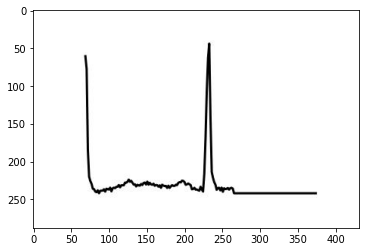

In [19]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [20]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    #shear_range = 0.2,
    #horizontal_flip=True,
    #zoom_range = 0.2,
    validation_split=0.25
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [22]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7200 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


In [23]:
test_generator.class_indices

{'F-resampled': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

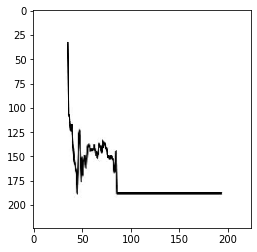

In [24]:
plt.imshow(test_generator[0][0][3])

In [25]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/S',
 '/content/ECG_Image_data/test/M',
 '/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/F-resampled',
 '/content/ECG_Image_data/test/Q']

In [26]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
for layer in vgg.layers:
  layer.trainable = False

In [28]:
x = Flatten()(vgg.output)

In [29]:
prediction = Dense(len(folders), activation='softmax')(x)

In [30]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [32]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)

Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.7535
Epoch 1: val_accuracy improved from -inf to 0.83042, saving model to best_model.h5
225/225 [==============================] - 48s 162ms/step - loss: 0.6870 - accuracy: 0.7535 - val_loss: 0.4811 - val_accuracy: 0.8304
Epoch 2/30
225/225 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8601
Epoch 2: val_accuracy improved from 0.83042 to 0.84625, saving model to best_model.h5
225/225 [==============================] - 36s 162ms/step - loss: 0.3906 - accuracy: 0.8601 - val_loss: 0.4279 - val_accuracy: 0.8462
Epoch 3/30
225/225 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8886
Epoch 3: val_accuracy improved from 0.84625 to 0.86958, saving model to best_model.h5
225/225 [==============================] - 36s 158ms/step - loss: 0.3139 - accuracy: 0.8886 - val_loss: 0.3696 - val_accuracy: 0.8696
Epoch 4/30
225/225 [==============================] - E

In [34]:
vgg_model.save('best.h5')

In [35]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.33277
Test Accuracy: 91.58%


In [36]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.33277
Test Accuracy: 91.58%


Text(0, 0.5, 'loss')

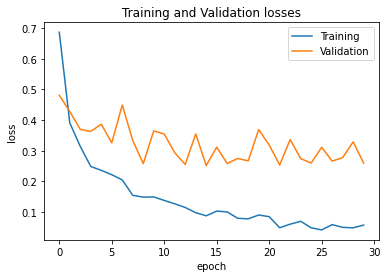

In [37]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

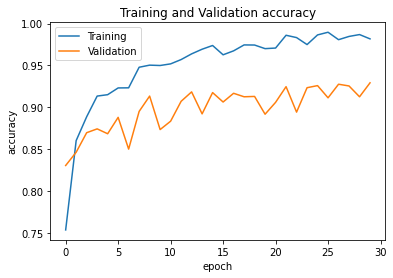

In [38]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [39]:
y_pred = best_model.predict(test_generator)
y_pred

75/75 [==============================] - 9s 119ms/step


array([[1.2400640e-10, 8.7666813e-10, 1.6089533e-06, 3.8288519e-04,
        6.2822181e-07, 9.9961483e-01],
       [8.1737106e-08, 9.8330450e-01, 1.6483638e-02, 1.9471868e-07,
        2.1157073e-04, 1.6017845e-08],
       [9.7475735e-05, 2.6091482e-04, 1.8213723e-03, 2.2917614e-07,
        8.7171614e-01, 1.2610395e-01],
       ...,
       [1.9708656e-05, 3.1708470e-03, 9.9653554e-01, 1.0327177e-06,
        1.9504240e-04, 7.7782162e-05],
       [6.1202571e-10, 3.3015122e-06, 2.4124994e-03, 2.5203495e-09,
        9.9758244e-01, 1.7781266e-06],
       [6.5326135e-06, 3.1116565e-03, 9.2396551e-01, 6.8570688e-02,
        3.2936113e-03, 1.0518965e-03]], dtype=float32)

In [40]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 1, 4, ..., 2, 4, 2])

In [41]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[356   3  13   0   4  24]
 [  0 371  20   1   6   2]
 [  2  16 354   7  19   2]
 [  0   0   1 395   2   2]
 [  0   6  33   0 351  10]
 [  8   1   8   1  11 371]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       400
           1       0.93      0.93      0.93       400
           2       0.83      0.89      0.85       400
           3       0.98      0.99      0.98       400
           4       0.89      0.88      0.89       400
           5       0.90      0.93      0.91       400

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



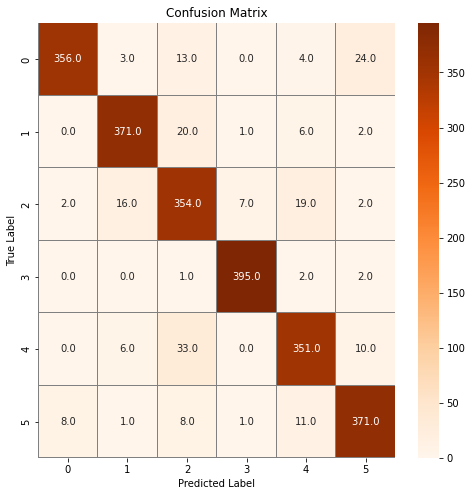

In [42]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 1s 738ms/step


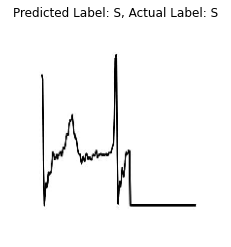

In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/S/115.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')

In [45]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [46]:
for layer in vgg.layers:
  layer.trainable = False

In [47]:
x = Flatten()(vgg.output)

In [48]:
prediction = Dense(len(folders), activation='softmax')(x)

In [49]:
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [50]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model2.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [51]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint,rp]
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.7196
Epoch 1: val_accuracy improved from -inf to 0.80417, saving model to best_model2.h5
225/225 [==============================] - 44s 190ms/step - loss: 0.7833 - accuracy: 0.7196 - val_loss: 0.5625 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8322
Epoch 2: val_accuracy improved from 0.80417 to 0.83958, saving model to best_model2.h5
225/225 [==============================] - 43s 189ms/step - loss: 0.4596 - accuracy: 0.8322 - val_loss: 0.4609 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8637
Epoch 3: val_accuracy improved from 0.83958 to 0.86125, saving model to best_model2.h5
225/225 [==============================] - 43s 189ms/step - loss: 0.3768 - accuracy: 0.8637 - val_loss: 0.3881 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 4/25
22

In [53]:
from keras.models import load_model
best_model=load_model('/content/best_model2.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.28861
Test Accuracy: 90.25%


Text(0, 0.5, 'loss')

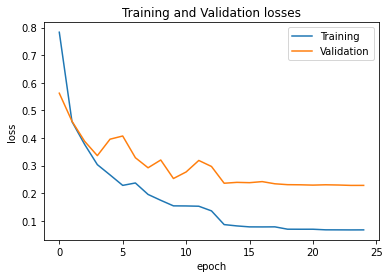

In [54]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

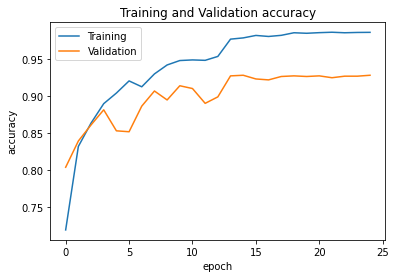

In [55]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [56]:
y_pred = best_model1.predict(test_generator)
y_pred

75/75 [==============================] - 9s 125ms/step


array([[1.2400640e-10, 8.7666813e-10, 1.6089533e-06, 3.8288519e-04,
        6.2822181e-07, 9.9961483e-01],
       [8.1737106e-08, 9.8330450e-01, 1.6483638e-02, 1.9471868e-07,
        2.1157073e-04, 1.6017845e-08],
       [9.7475735e-05, 2.6091482e-04, 1.8213723e-03, 2.2917614e-07,
        8.7171614e-01, 1.2610395e-01],
       ...,
       [1.9708656e-05, 3.1708470e-03, 9.9653554e-01, 1.0327177e-06,
        1.9504240e-04, 7.7782162e-05],
       [6.1202571e-10, 3.3015122e-06, 2.4124994e-03, 2.5203495e-09,
        9.9758244e-01, 1.7781266e-06],
       [6.5326135e-06, 3.1116565e-03, 9.2396551e-01, 6.8570688e-02,
        3.2936113e-03, 1.0518965e-03]], dtype=float32)

In [57]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 1, 4, ..., 2, 4, 2])

In [58]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[356   3  13   0   4  24]
 [  0 371  20   1   6   2]
 [  2  16 354   7  19   2]
 [  0   0   1 395   2   2]
 [  0   6  33   0 351  10]
 [  8   1   8   1  11 371]]
classification report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       400
           1       0.93      0.93      0.93       400
           2       0.83      0.89      0.85       400
           3       0.98      0.99      0.98       400
           4       0.89      0.88      0.89       400
           5       0.90      0.93      0.91       400

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



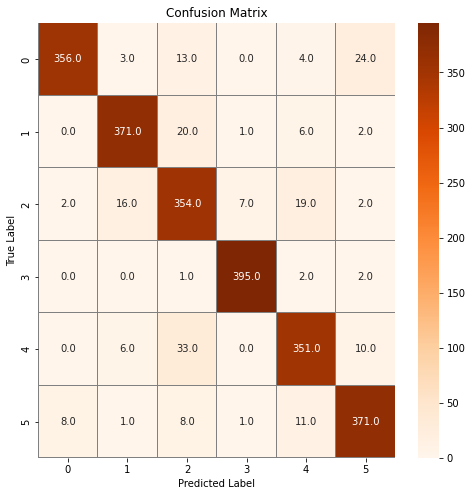

In [59]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [60]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 0s 24ms/step


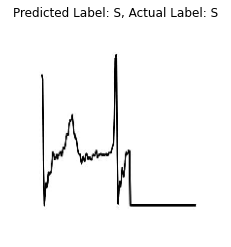

In [61]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/S/115.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='S')

In [62]:
model1=load_model('best_model.h5')
model2=load_model('best_model2.h5')

In [63]:
model1=Model(inputs=model1.inputs,outputs=model1.outputs,name='VGG16')

In [64]:
model2=Model(inputs=model2.inputs,outputs=model2.outputs,name='VGG19')

In [65]:
models=[model1,model2]

In [66]:
model_input=Input(shape=(224,224,3))

In [67]:
model_outputs=[model(model_input) for model in models]

In [68]:
ensemble_output=Average()(model_outputs)

In [69]:
ensemble_model=Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [70]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model3.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [71]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [72]:
history=ensemble_model.fit(train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[checkpoint])

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9786
Epoch 1: val_accuracy improved from -inf to 0.93375, saving model to best_model3.h5
225/225 [==============================] - 78s 340ms/step - loss: 0.0895 - accuracy: 0.9786 - val_loss: 0.2374 - val_accuracy: 0.9337
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9785
Epoch 2: val_accuracy did not improve from 0.93375
225/225 [==============================] - 76s 339ms/step - loss: 0.0850 - accuracy: 0.9785 - val_loss: 0.2623 - val_accuracy: 0.9242
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9828
Epoch 3: val_accuracy did not improve from 0.93375
225/225 [==============================] - 75s 334ms/step - loss: 0.0689 - accuracy: 0.9828 - val_loss: 0.2410 - val_accuracy: 0.9329
Epoch 4/25
225/225 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9787
Epoch 4: val_accuracy did no

In [73]:
from keras.models import load_model
results1 = ensemble_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.52203
Test Accuracy: 90.83%


In [74]:
from keras.models import load_model
best_model2=load_model('/content/best_model3.h5')
results = best_model2.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.32512
Test Accuracy: 92.00%


Text(0, 0.5, 'loss')

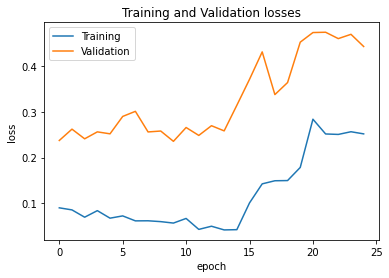

In [75]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

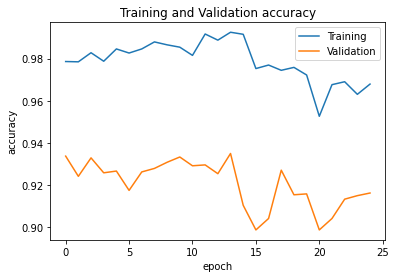

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [77]:
y_pred = best_model2.predict(test_generator)
y_pred

75/75 [==============================] - 19s 246ms/step


array([[3.4549448e-09, 7.6549017e-11, 1.8242567e-07, 3.3447266e-04,
        3.3745414e-07, 9.9966490e-01],
       [4.3937000e-08, 9.9848497e-01, 1.2748874e-03, 1.1175418e-07,
        2.4005072e-04, 4.0798781e-10],
       [6.5759820e-04, 2.5886003e-02, 1.1475278e-03, 1.7336772e-05,
        5.7513142e-01, 3.9716014e-01],
       ...,
       [1.3519683e-05, 1.7577845e-03, 9.9771237e-01, 3.2883037e-07,
        4.8231526e-04, 3.3654971e-05],
       [9.5309932e-12, 2.6845277e-07, 7.2350180e-05, 4.2404494e-10,
        9.9992734e-01, 6.8892170e-08],
       [1.5750091e-05, 2.6557013e-01, 6.9528735e-01, 1.8823169e-02,
        1.8982213e-02, 1.3213420e-03]], dtype=float32)

In [78]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 1, 4, ..., 2, 4, 2])

In [79]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[372   3   8   0   2  15]
 [  0 389   5   0   6   0]
 [  5  36 325   4  29   1]
 [  0   0   0 397   2   1]
 [  1  10  22   0 361   6]
 [ 11   6   6   1  12 364]]
classification report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       400
           1       0.88      0.97      0.92       400
           2       0.89      0.81      0.85       400
           3       0.99      0.99      0.99       400
           4       0.88      0.90      0.89       400
           5       0.94      0.91      0.93       400

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



In [ ]:
model3=load_model('best_model5.h5')

In [ ]:
model3=Model(inputs=model3.inputs,outputs=model3.outputs,name='CNN')

In [ ]:
models=[model1,model3]

In [ ]:
preds=[model.predict(test_generator) for model in models]

In [ ]:
preds=np.array(preds)

In [ ]:
summed=np.sum(preds,axis=0)

In [ ]:
ensemble_prediction=np.argmax(summed,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
ensemble_accuracy=accuracy_score(test_generator.labels,ensemble_prediction)

In [ ]:
print(ensemble_accuracy)

In [ ]:
print(classification_report(test_generator.labels,ensemble_prediction))